# Last Phase: Testing our created models

Now that we have created quite a few models it's useful now to see how they can compare to each other. We used the evaluation dataset not to train the model, but to instead validate the development process. It's not a good idea to evaluate different models ones against each other with the same evaluation dataset, this because the validation set was not used directly for training, but has influenced the model, in a way "seeing" the data.

By using a separate test data that has not been used at all during training we could get a better estimate on how different models will behave in the real world, on data never seen before.

We've modified slightly the previous notebook for this purpose


In [1]:
import sys
sys.path.insert(0, './src')
import utils



import albumentations as A
import os
import torch
import torch.nn as nn
import warnings
import torch.utils.data as data
from rasterio.errors import NotGeoreferencedWarning
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning) # Masks are not georeferences, so we can ignore this warning
warnings.filterwarnings("ignore", category=UserWarning) # This will throw a warning message about cudnn, this is normal (https://github.com/pytorch/pytorch/pull/125790)

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:
# MEAN = [63.02235933, 66.64201154, 60.63862196]
# STD = [55.50368184, 55.35826425, 52.63471437]
MEAN = [0, 0, 0]
STD = [1.0, 1.0, 1.0]
MAX_LR = 1e-4
VAL_SIZE = 360
NUM_WORKERS = 4
VAL_BATCH_SIZE = 4
LOAD_BEST = True
EPOCHS = 24
NAME = "6 - LR1e-4 TrainBatch8 Epoch80 Resize - NoAugmentation"

DATASET_PATH = "data/train/AOI_11_Rotterdam/"
OUTPUT_PATH = "output/"
DATA_PATH = OUTPUT_PATH + "data/" + NAME + "/"
CHECKPOINT_PATH = OUTPUT_PATH + "checkpoints/"
GRAPH_PATH = OUTPUT_PATH + "graphs/"

We'll reimport the default values that we had from before

We slightly modified the values of the transformations! We're having a better alignment, and using A.RandomCrop is better than A.Resize because you don't loose details

Using PyTorch version: 2.3.0+cu121  Device: cuda
PyTorch version:  2.3.0+cu121
CUDA version:  12.1
cuDNN version:  8902
CUDA Device Name:  NVIDIA GeForce RTX 2060
Image shape: torch.Size([4, 3, 360, 360]), Mask shape: torch.Size([4, 1, 360, 360])


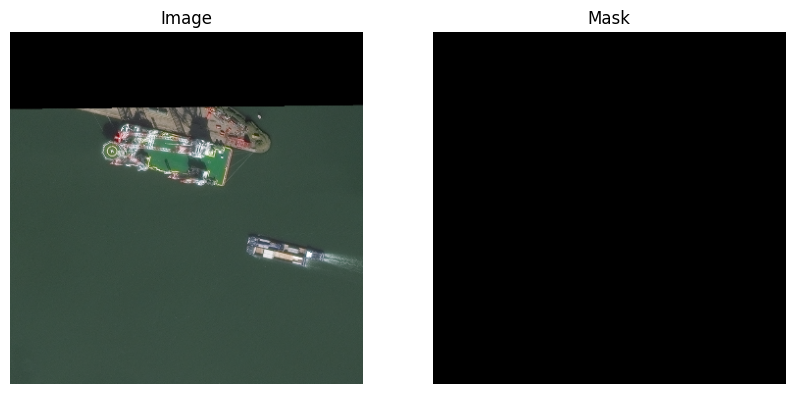

In [3]:
device = utils.set_cuda_and_seed()

print("PyTorch version: ", torch.__version__)
print("CUDA version: ", torch.version.cuda)
print("cuDNN version: ", torch.backends.cudnn.version())
print("CUDA Device Name: ", torch.cuda.get_device_name())

eval_transforms = A.Compose([
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=255.0),
    A.CenterCrop(896, 896),
    A.Resize(VAL_SIZE, VAL_SIZE)
])
from dataset import SN6Dataset

test_dataset = SN6Dataset(DATASET_PATH, transform=eval_transforms, split='test')
test_loader = data.DataLoader(test_dataset, pin_memory = True, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

image, mask = next(iter(test_loader))
print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
utils.visualize_image(image[0], mask[0])

We'll be trying something new: A custom loss function that connects both BCEWithLogitLoss and a custom-made Dice loss (since we already established it's our best parameter) in a 50/50 mix. It's been implemented in _custom_loss.py_

we'll try to work on 
 - Normalization
 - A better Segmentation
 - Maybe slowing down the learning rate even further
 

In [4]:
from model import UNET

model = UNET(in_channels = 3, out_channels = 1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=MAX_LR, weight_decay=1e-5)

# We won't use a scheduler at first, but we'll add it later
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=MAX_LR, steps_per_epoch=len(test_loader), epochs=EPOCHS)
scaler = torch.cuda.amp.GradScaler()


We'll modify the functions to show the image so that we can do some evaluations of the models

In [5]:
import matplotlib.pyplot as plt

# Get the history
history = utils.load_checkpoint(CHECKPOINT_PATH + f"checkpoint_{NAME}.pth", model)
# Get a random image from the test set
image, mask, pred = utils.get_random_image(test_loader, model, device)
# Print statistics from the get_evals function
eval_loss, precision, recall, f1, accuracy = utils.get_evals(test_loader, model, criterion, device, save_predictions=True, output_path=DATA_PATH)
print(f"Eval loss: {eval_loss:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f} Accuracy: {accuracy:.4f}")
utils.visualize_image(image.cpu(), mask.cpu(), pred.cpu(), save_path = GRAPH_PATH + f"image_{NAME}.png")

""" train_loss = history['train_loss']
eval_loss = history['val_loss']
precision = history['precision']
recall = history['recall']
accuracy = history['accuracy']
f1_score = history['f1']
# Plot the loss and other metrics
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')   
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss, label='Train Loss')
plt.plot(eval_loss, label='Eval Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Metrics')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.plot(precision, label='Precision')
plt.plot(recall, label='Recall')
plt.plot(accuracy, label='Accuracy')
plt.plot(f1_score, label='F1 Score')
plt.legend()
plt.tight_layout()
plt.savefig(GRAPH_PATH + f"metrics_{NAME}.png")
plt.show() """

loading checkpoint


FileNotFoundError: [Errno 2] No such file or directory: 'output/checkpoints/checkpoint_6 - LR1e-4 TrainBatch8 Epoch80 Resize NoAugmentation.pth'